In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from bs4 import BeautifulSoup
import re
import json
import requests

In [2]:
URL = "https://storage.googleapis.com/geotab_wfm_production_cms_storage/CMS-GeneralFiles-production/NA/EV/EVTOOL.html"

In [3]:
r = requests.get(URL)
source = BeautifulSoup(r.content, "html.parser")

In [4]:
car_data = source.find_all("script")[0].string

In [5]:
json_obj = json.loads(car_data.lstrip("\r\n    const EV_DATA = "))

In [6]:
json_obj['Tesla Model 3 ']

{'2018': {'54': {'MMY': 'Tesla Model 3 2018',
   'Make': 'Tesla',
   'Model': 'Model 3 ',
   'Trim details': '',
   'Year': '2018',
   'Median peak fuel efficieny (21C) wh/km': '157.6561135',
   'Battery size (kwh) - at purchase': '54',
   '21C range (km)-original': '342.5176404',
   'Powertrain': 'EV'}},
 '2019': {'54': {'MMY': 'Tesla Model 3 2019',
   'Make': 'Tesla',
   'Model': 'Model 3 ',
   'Trim details': '',
   'Year': '2019',
   'Median peak fuel efficieny (21C) wh/km': '152.44',
   'Battery size (kwh) - at purchase': '54',
   '21C range (km)-original': '354',
   'Powertrain': 'EV'}}}

In [8]:
factor_data = source.find_all("script")[2].string
factor_data = factor_data.lstrip("\r\n    const TEMP_DATA = ")

In [10]:
f_list = json.loads(factor_data)

In [11]:
f_list[0]

{'Temp': '-23',
 'Range factor relative 21C - overall - Not Tesla': '0.423087273',
 'Range factor relative 21C - 90th - Not Tesla': '0.542401766',
 'Range factor relative 21C - 10th - Not Tesla': '0.293100333',
 'Range factor relative 21C - overall - Tesla': '#N/A',
 'Range factor relative 21C - 90th - Tesla': '#N/A',
 'Range factor relative 21C - 10th - Tesla': '#N/A'}

In [12]:
temps = np.zeros(len(f_list))
tesla_factor = np.zeros(len(f_list))
not_tesla_factor = np.zeros(len(f_list))

In [13]:
for i, f in zip(range(len(f_list)), f_list):
    temps[i] = f["Temp"]
    not_tesla_factor[i] = f["Range factor relative 21C - overall - Not Tesla"]
    if f["Range factor relative 21C - overall - Tesla"] == '#N/A':
        tesla_factor[i] = np.nan
    else:
        tesla_factor[i] = f["Range factor relative 21C - overall - Tesla"]

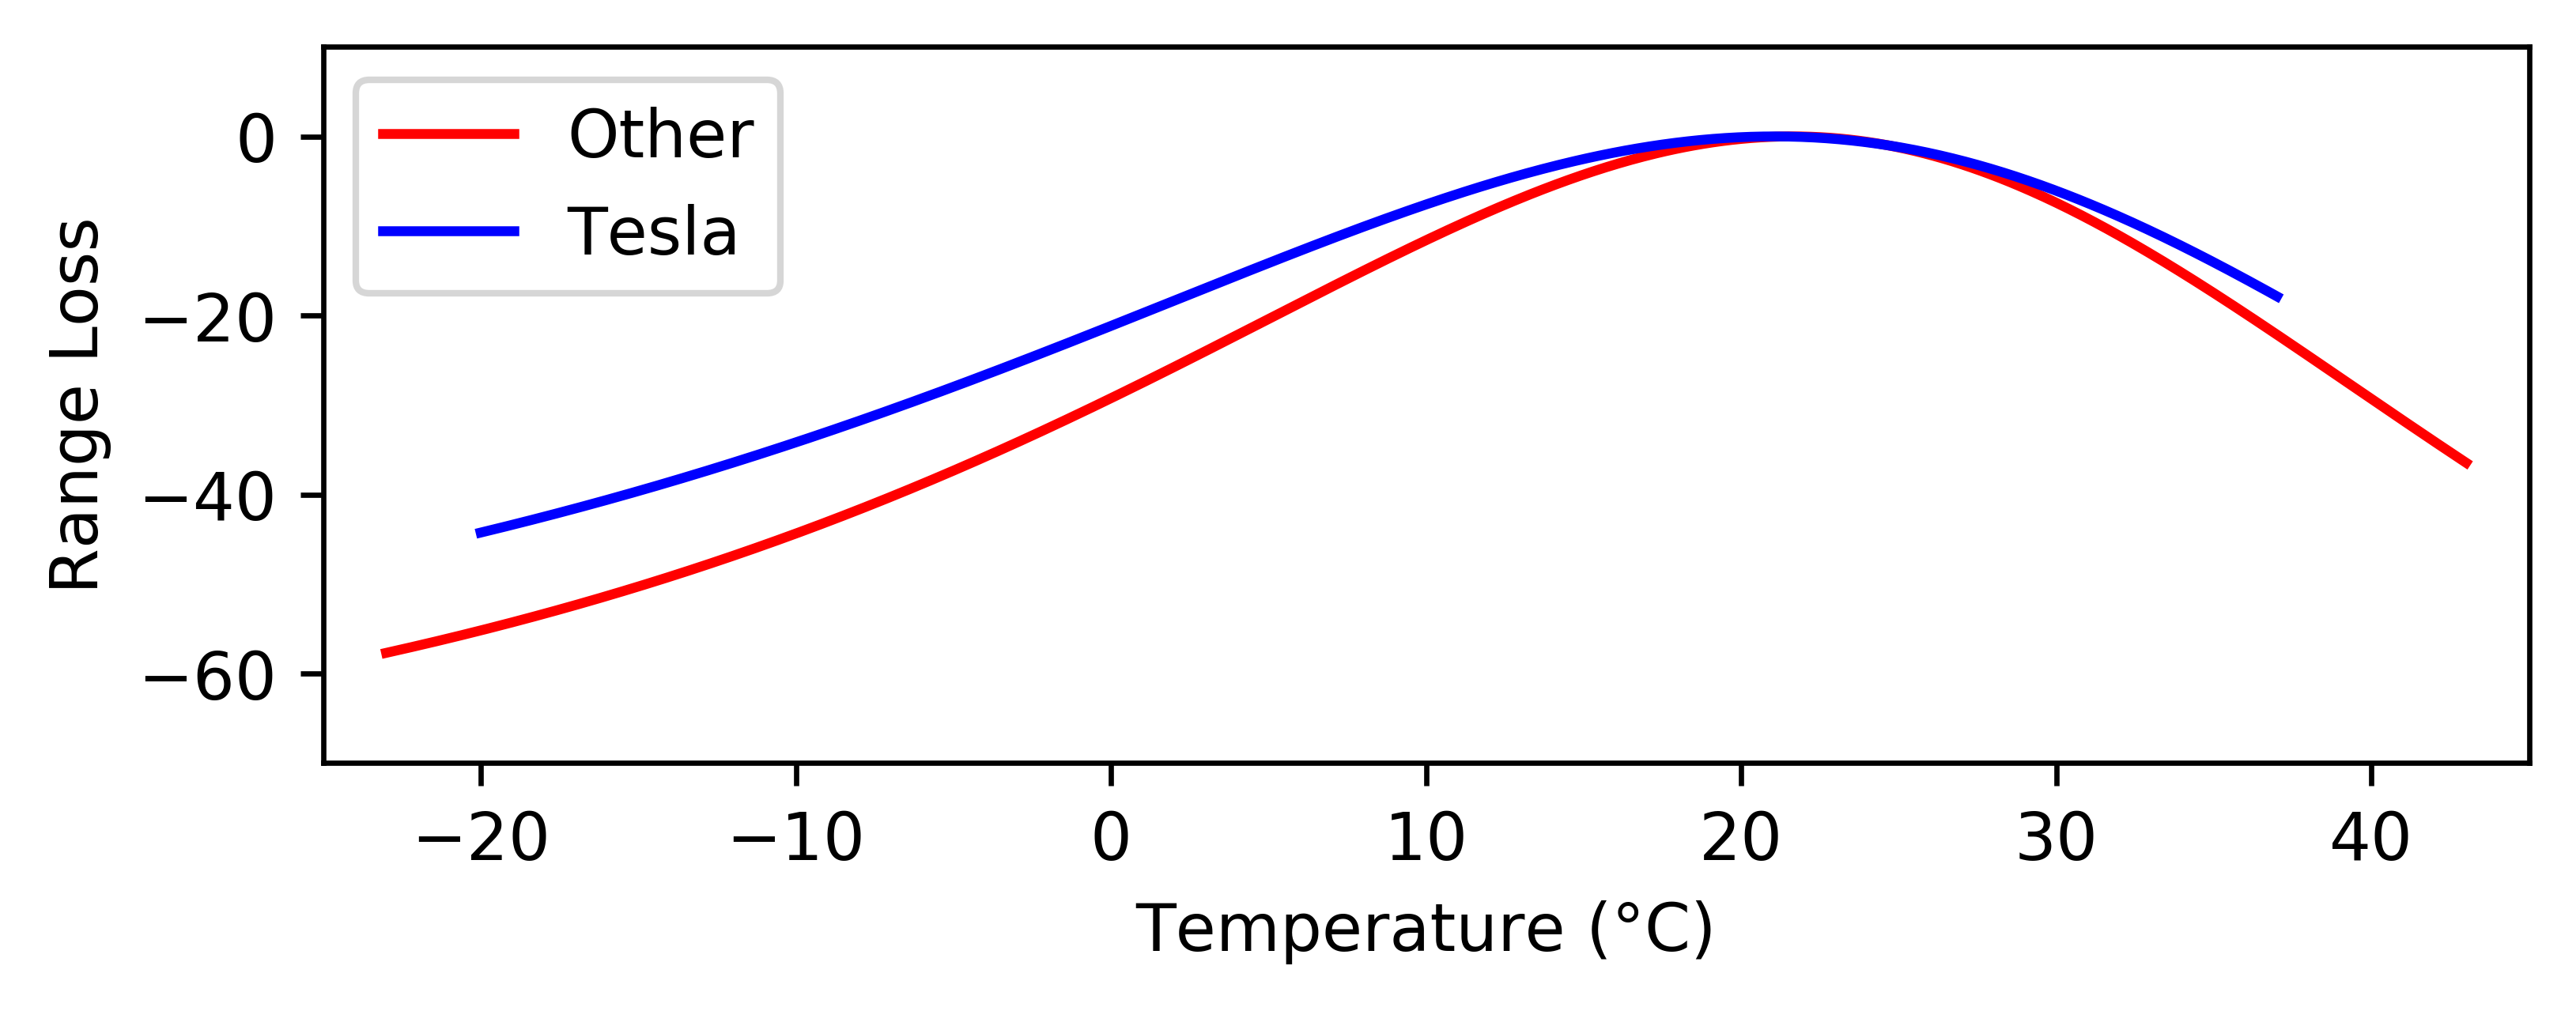

In [15]:
plt.figure(figsize=(6, 2), dpi=600)
plt.plot(temps, not_tesla_factor*100-100, c='r', label="Other")
plt.plot(temps, tesla_factor*100-100, c='b', label="Tesla")
plt.xlim((-25, 45))
plt.ylim((-70, 10))
plt.xlabel("Temperature (°C)")
plt.ylabel("Range Loss")

plt.legend()

In [16]:
df = pd.DataFrame([temps, tesla_factor, not_tesla_factor]).transpose()

In [17]:
df.columns = ["Temperature", "Tesla Factors", "Not Tesla Factors"]

In [18]:
df.to_csv("scale_factors.csv",index=False)